In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
from torchvision import datasets, transforms

In [2]:
Data = []
Label = []

pad1d = lambda a,i : a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a,i : a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i - a.shape[1]))))

In [23]:
DATA_DIR = 'C:/Users/ADmin/Desktop/train/audio/'
num = {'zero/' : 0,'one/' : 1,'two/' : 2,'three/' : 3,'four/' : 4,'five/' : 5,'six/' : 6,'seven/' : 7,'eight/' : 8,'nine/' : 9}

for n_folder,n in num.items():
    for fname in os.listdir(DATA_DIR + n_folder):
        wav, _ = librosa.load(DATA_DIR + n_folder + fname)

        Data.append(wav)
        Label.append(n)

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(Data, Label, test_size = 0.2,random_state = 123, shuffle = True, stratify = Label)

In [39]:
train_X = []
train_mfccs = []
train_y = []

#STFT한것, CNN분석하기 위해 Spectrogram으로 만든 것, MF한것, mel-spectorgram한것

for i in range(len(X_train)):
    wav = X_train[i]
    label = y_train[i]

    padded_x = pad1d(wav, 30000)

    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc,200)

    train_X.append(padded_x)
    train_mfccs.append(padded_mfcc) 
    train_y.append(label)

valid_X = []
valid_mfccs = []
valid_y = []

for i in range(len(X_valid)):
    wav = X_valid[i]
    label = y_valid[i]

    padded_x = pad1d(wav, 30000)

    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc,200)

    valid_X.append(padded_x)
    valid_mfccs.append(padded_mfcc) 
    valid_y.append(label)

In [40]:
train_X = torch.cuda.FloatTensor(train_X)
train_mfccs = torch.cuda.FloatTensor(train_mfccs)
train_y = torch.cuda.LongTensor(train_y)

train_mfccs = train_mfccs.unsqueeze(1)

valid_X = torch.cuda.FloatTensor(valid_X)
valid_mfccs = torch.cuda.FloatTensor(valid_mfccs)
valid_y = torch.cuda.LongTensor(valid_y)

valid_mfccs = valid_mfccs.unsqueeze(1)

print('train_X: ', train_X.shape)
print('train_mfccs: ', train_mfccs.shape)
print('train_y: ', train_y.shape)
print('----------------------------------')
print("valid_X: ", valid_X.shape)
print("valid_mfccs: ", valid_mfccs.shape)
print("valid_y: ", valid_y.shape)

train_X:  torch.Size([19412, 30000])
train_mfccs:  torch.Size([19412, 1, 20, 200])
train_y:  torch.Size([19412])
----------------------------------
valid_X:  torch.Size([4854, 30000])
valid_mfccs:  torch.Size([4854, 1, 20, 200])
valid_y:  torch.Size([4854])


In [41]:
train_data = TensorDataset(train_mfccs, train_y)
train_data = DataLoader(train_data, batch_size=40, drop_last=False, shuffle=True)

valid_data = TensorDataset(valid_mfccs, valid_y)
valid_data = DataLoader(valid_data, batch_size=40, drop_last=False, shuffle=True)

In [42]:
len(train_data.dataset)

19412

In [54]:
use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(1, 32, 2) # 1@20*200 -> 32@19*199
        pool1 = nn.MaxPool2d(2,2) # 32@9*99
        conv2 = nn.Conv2d(32, 64, 2) # 32@9*99 -> 64@8*98
        conv2_bn = nn.BatchNorm2d(64)
        pool2 = nn.MaxPool2d(2,2) # 64@8*98 -> 64@4*49
        conv3 = nn.Conv2d(64, 128, 2) # 64@4*49 -> 128@3*48
        conv3_bn = nn.BatchNorm2d(128)
        pool3 = nn.MaxPool2d(2,2) # 128@3*48 -> 128@1*24
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            conv2_bn,
            nn.ReLU(),
            pool2,
            conv3,
            conv3_bn,
            nn.ReLU(),
            pool3
        )
        
        fc1 = nn.Linear(128*1*24, 64)
        fc1_bn = nn.BatchNorm1d(64)
        fc2 = nn.Linear(64, 32)
        fc2_bn = nn.BatchNorm1d(32)
        fc3 = nn.Linear(32, 10)
        
        self.fc_module = nn.Sequential(
            fc1,
            fc1_bn,
            nn.ReLU(),
            fc2,
            fc2_bn,
            nn.ReLU(),
            fc3
        )
        
    def forward(self, x):
        out = self.conv_module(x) # @128*254*7
        dim = 1
        for d in out.size()[1:]:
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [55]:
from torchsummary import summary # from torch.autograd import Variable

cnn = CNNClassifier().cuda()
input_size = (1, 20, 200)
summary(cnn, input_size) #mfcc - input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 19, 199]             160
              ReLU-2          [-1, 32, 19, 199]               0
         MaxPool2d-3            [-1, 32, 9, 99]               0
            Conv2d-4            [-1, 64, 8, 98]           8,256
       BatchNorm2d-5            [-1, 64, 8, 98]             128
              ReLU-6            [-1, 64, 8, 98]               0
         MaxPool2d-7            [-1, 64, 4, 49]               0
            Conv2d-8           [-1, 128, 3, 48]          32,896
       BatchNorm2d-9           [-1, 128, 3, 48]             256
             ReLU-10           [-1, 128, 3, 48]               0
        MaxPool2d-11           [-1, 128, 1, 24]               0
           Linear-12                   [-1, 64]         196,672
      BatchNorm1d-13                   [-1, 64]             128
             ReLU-14                   

In [56]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

num_epochs = 30
num_batches = len(train_data)

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

train_total = 0
train_correct = 0
train_incorrect = 0
valid_total = 0
valid_correct = 0
valid_incorrect = 0

for epoch in range(num_epochs):
    
    train_loss = 0.0
    for i, data in enumerate(train_data):
        x, label = data

        if use_cuda:
            x = x.cuda()
            label = label.cuda()

        optimizer.zero_grad()
        model_output = cnn(x)
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()/len(train_data.dataset)
        del loss
        
        for ix in range(len(model_output)):
            if torch.argmax(model_output[ix]).item() == label[ix].item():
                train_correct += 1
            else:
                train_incorrect += 1
        
        if (i+1) % num_batches == 0:
            with torch.no_grad():
                valid_loss = 0.0
                for j, valid in enumerate(valid_data):
                    valid_x, valid_label = valid
                    if use_cuda:
                        valid_x = valid_x.cuda()
                        valid_label = valid_label.cuda()
                    valid_output = cnn(valid_x)
                    v_loss = criterion(valid_output, valid_label)
                    valid_loss += v_loss/len(valid_data.dataset)
                    
                    for idx in range(len(valid_output)):
                        if torch.argmax(valid_output[idx]).item() == valid_label[idx].item():
                            valid_correct += 1
                        else:
                            valid_incorrect += 1                  

            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, train_loss, valid_loss
            ))            
            
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            train_loss = 0.0
    train_accuracy.append((train_correct/(train_correct+train_incorrect))*100)
    valid_accuracy.append((valid_correct/(valid_correct+valid_incorrect))*100)

print('Accuracy of the network on the train audio: %f %%' % (train_accuracy[-1]))
print('Accuracy of the network on the test audio: %f %%' % (valid_accuracy[-1]))

epoch: 1/30 | step: 486/486 | trn loss: 0.0482 | val loss: 0.0428
epoch: 2/30 | step: 486/486 | trn loss: 0.0405 | val loss: 0.0399
epoch: 3/30 | step: 486/486 | trn loss: 0.0391 | val loss: 0.0393
epoch: 4/30 | step: 486/486 | trn loss: 0.0387 | val loss: 0.0390
epoch: 5/30 | step: 486/486 | trn loss: 0.0384 | val loss: 0.0389
epoch: 6/30 | step: 486/486 | trn loss: 0.0381 | val loss: 0.0387
epoch: 7/30 | step: 486/486 | trn loss: 0.0380 | val loss: 0.0386
epoch: 8/30 | step: 486/486 | trn loss: 0.0379 | val loss: 0.0384
epoch: 9/30 | step: 486/486 | trn loss: 0.0378 | val loss: 0.0386
epoch: 10/30 | step: 486/486 | trn loss: 0.0377 | val loss: 0.0386
epoch: 11/30 | step: 486/486 | trn loss: 0.0377 | val loss: 0.0384
epoch: 12/30 | step: 486/486 | trn loss: 0.0376 | val loss: 0.0386
epoch: 13/30 | step: 486/486 | trn loss: 0.0375 | val loss: 0.0385
epoch: 14/30 | step: 486/486 | trn loss: 0.0375 | val loss: 0.0385
epoch: 15/30 | step: 486/486 | trn loss: 0.0374 | val loss: 0.0384
epoc

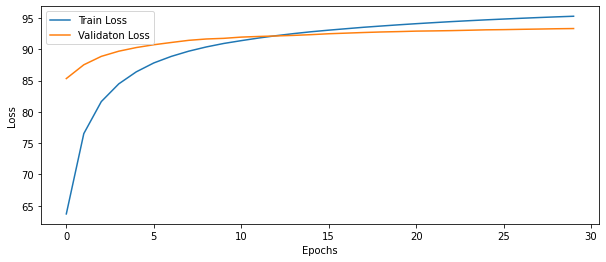

In [57]:
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(train_accuracy, label = 'Train Loss')
plt.plot(valid_accuracy, label = 'Validaton Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [58]:
print("cnn's state_dict:")
for param_tensor in cnn.state_dict():
    print(param_tensor, "\t", cnn.state_dict()[param_tensor].size())
    
#print("Optimizer's state_dict:")
#for var_name in optimizer.cnn_dict():
#    print(var_name, "\t", optimizer.cnn_dict()[var_name])

cnn's state_dict:
conv_module.0.weight 	 torch.Size([32, 1, 2, 2])
conv_module.0.bias 	 torch.Size([32])
conv_module.3.weight 	 torch.Size([64, 32, 2, 2])
conv_module.3.bias 	 torch.Size([64])
conv_module.4.weight 	 torch.Size([64])
conv_module.4.bias 	 torch.Size([64])
conv_module.4.running_mean 	 torch.Size([64])
conv_module.4.running_var 	 torch.Size([64])
conv_module.4.num_batches_tracked 	 torch.Size([])
conv_module.7.weight 	 torch.Size([128, 64, 2, 2])
conv_module.7.bias 	 torch.Size([128])
conv_module.8.weight 	 torch.Size([128])
conv_module.8.bias 	 torch.Size([128])
conv_module.8.running_mean 	 torch.Size([128])
conv_module.8.running_var 	 torch.Size([128])
conv_module.8.num_batches_tracked 	 torch.Size([])
fc_module.0.weight 	 torch.Size([64, 3072])
fc_module.0.bias 	 torch.Size([64])
fc_module.1.weight 	 torch.Size([64])
fc_module.1.bias 	 torch.Size([64])
fc_module.1.running_mean 	 torch.Size([64])
fc_module.1.running_var 	 torch.Size([64])
fc_module.1.num_batches_tracked 

In [59]:
torch.save(cnn.state_dict(), 'G:/2020/KIST/2. code/Python/Audio/Deep Learning/Model_1/cnn.pt')
#cnn.load_state_dict(torch.load("G:\2020\KIST\2. code\Python\Audio\Deep Learning\Model_1"))
#cnn.eval()